In [1]:
import xarray as xr
import os
import pandas as pd
import tqdm
import numpy as np
import time
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from netCDF4 import Dataset
import cmocean

from collections import OrderedDict
from itertools import product
import math
from netCDF4 import Dataset
from cdo import *   # python version
cdo = Cdo()
import matplotlib.pylab as plt
%matplotlib inline

In [29]:
# parameters cell
input_paths = ['/p/largedata/hhb19/jstreffi/runtime/awicm-3.1/HIST/outdata/oifs/links/']

input_names = ['HIST']
climatology_files = ['CERES_EBAF_Ed4.1_Subset_CLIM01-CLIM12.nc']
climatology_path = '/p/project/chhb19/streffing1/obs/CERES/'
accumulation_period = 21600 # For fluxes that are accumulated -> output frequency of OpenIFS in seconds e.g. 21600s = 3h
exps = range(7, 9)
figsize=(6, 4.5)
dpi = 300
ofile = None
res = [360, 180]
variable = ['SSRD']
variable_clim = 'sfc_sw_down_all_clim'
mapticks = [-50,-30,-20,-10,-6,-2,2,6,10,20,30,50]

contour_outline_thickness = 0
levels = np.linspace(-5, 5, 21)


In [18]:
def define_rowscol(input_paths, columns=len(input_paths), reduce=0):
    number_paths = len(input_paths) - reduce
#     columns = columns
    if number_paths < columns:
        ncol = number_paths
    else:
        ncol = columns
    nrows = math.ceil(number_paths / columns)
    return [nrows, ncol]

In [19]:
# Load CERES satobs data (https://doi.org/10.1175/JCLI-D-17-0208.1)

CERES_path = climatology_path+climatology_files[0]
CERES_Dataset = Dataset(CERES_path)
CERES_Data = OrderedDict()
CERES_CRF = CERES_Dataset.variables[variable_clim][:]

/tmp/ipykernel_6231/3434423090.py:6: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  CERES_CRF = CERES_Dataset.variables[variable_clim][:]
/tmp/ipykernel_6231/3434423090.py:6: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  CERES_CRF = CERES_Dataset.variables[variable_clim][:]


In [20]:
# Load model data

data = OrderedDict()
for exp_path, exp_name  in zip(input_paths, input_names):
    data[exp_name] = {}
    for v in variable:
        paths = []
        data[exp_name][v] = []
        for exp in tqdm.tqdm(exps):
            path = exp_path+'/'+v+'_'+f'{exp:05d}.nc'
            data[exp_name][v].append(cdo.yearmean(input="-remapcon,r"+str(res[0])+"x"+str(res[1])+" "+str(path),returnArray=v)/accumulation_period)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.85s/it]


(180, 360)
(180, 360)
(180, 361)
(180, 361)


convert: unable to open image 'sw_rad_vs_ceres': No such file or directory @ error/blob.c/OpenBlob/3533.
convert: no decode delegate for this image format `' @ error/constitute.c/ReadImage/572.
convert: no images defined `sw_rad_vs_ceres_trimmed.png' @ error/convert.c/ConvertImageCommand/3322.
mv: cannot stat 'sw_rad_vs_ceres_trimmed.png': No such file or directory


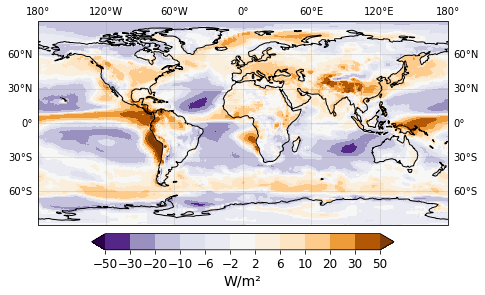

In [58]:
crf_sw_model = OrderedDict()
crf_sw_model_mean = OrderedDict()


for exp_name in input_names:
    crf_sw_model[exp_name] = np.squeeze(data[exp_name]['SSRD']) 
    crf_sw_model_mean[exp_name] = np.mean(crf_sw_model[exp_name],axis=0)
    if len(np.shape(crf_sw_model_mean[exp_name])) > 2:
        crf_sw_model_mean[exp_name] = np.mean(crf_sw_model_mean[exp_name],axis=0)
crf_sw_satobs_mean = np.mean(CERES_CRF,axis=0)

print(np.shape(crf_sw_model_mean[exp_name]))
print(np.shape(crf_sw_satobs_mean))

lon = np.arange(0, 360, 1)
lat = np.arange(-90, 90, 1)
crf_sw_model_mean[exp_name], lon = add_cyclic_point(crf_sw_model_mean[exp_name], coord=lon)

lon = np.arange(0, 360, 1)
lat = np.arange(-90, 90, 1)
crf_sw_satobs_mean, lon = add_cyclic_point(crf_sw_satobs_mean, coord=lon)

print(np.shape(crf_sw_model_mean[exp_name]))
print(np.shape(crf_sw_satobs_mean))





nrows, ncol = define_rowscol(input_paths)
fig, axes = plt.subplots(nrows=nrows, ncols=ncol, figsize=figsize)
if isinstance(axes, np.ndarray):
    axes = axes.flatten()
else:
    axes = [axes]
i = 0


for key in input_names:

    axes[i]=plt.subplot(nrows,ncol,i+1,projection=ccrs.PlateCarree())
    axes[i].add_feature(cfeature.COASTLINE,zorder=3)
    
    
    imf=plt.contourf(lon, lat, crf_sw_model_mean[exp_name]-
                     crf_sw_satobs_mean, cmap='PuOr_r', 
                     levels=mapticks, extend='both',
                     transform=ccrs.PlateCarree(),zorder=1)
    line_colors = ['black' for l in imf.levels]
    imc=plt.contour(lon, lat, crf_sw_model_mean[exp_name]-
                    crf_sw_satobs_mean, colors=line_colors, 
                    levels=mapticks, linewidths=contour_outline_thickness,
                    transform=ccrs.PlateCarree(),zorder=1)

    axes[i].set_ylabel('W/m²')
    axes[i].set_xlabel('Simulation Year')
    
    #axes[i].set_title(key)
    plt.tight_layout() 

    cbar_ax_abs = fig.add_axes([0.15, 0.11, 0.7, 0.05])
    cbar_ax_abs.tick_params(labelsize=12)
    cb = fig.colorbar(imf, cax=cbar_ax_abs, orientation='horizontal',ticks=mapticks)
    cb.set_label(label="W/m²", size='14')
    cb.ax.tick_params(labelsize='12')
    
    gl = axes[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.2, linestyle='-')

    gl.xlabels_bottom = False

    i = i+1
    
    
ofile='sw_rad_vs_ceres'
    
if ofile is not None:
    plt.savefig(ofile, dpi=dpi,bbox_inches='tight')
    os.system(f'convert {ofile} -trim {ofile}_trimmed.png')
    os.system(f'mv {ofile}_trimmed.png {ofile}')

(180, 360)
(180, 360)
(180, 361)
(180, 361)


/tmp/ipykernel_6231/2499340254.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
convert: unable to open image 'relative_sw_rad_vs_ceres': No such file or directory @ error/blob.c/OpenBlob/3533.
convert: no decode delegate for this image format `' @ error/constitute.c/ReadImage/572.
convert: no images defined `relative_sw_rad_vs_ceres_trimmed.png' @ error/convert.c/ConvertImageCommand/3322.
mv: cannot stat 'relative_sw_rad_vs_ceres_trimmed.png': No such file or directory


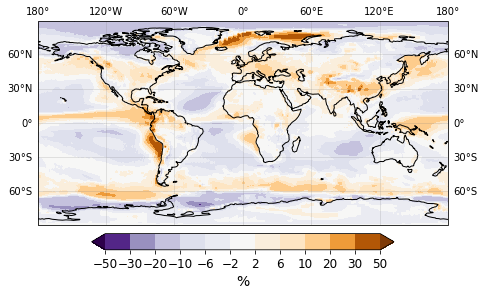

In [57]:
crf_sw_model = OrderedDict()
crf_sw_model_mean = OrderedDict()


for exp_name in input_names:
    crf_sw_model[exp_name] = np.squeeze(data[exp_name]['SSRD']) 
    crf_sw_model_mean[exp_name] = np.mean(crf_sw_model[exp_name],axis=0)
    if len(np.shape(crf_sw_model_mean[exp_name])) > 2:
        crf_sw_model_mean[exp_name] = np.mean(crf_sw_model_mean[exp_name],axis=0)
crf_sw_satobs_mean = np.mean(CERES_CRF,axis=0)

print(np.shape(crf_sw_model_mean[exp_name]))
print(np.shape(crf_sw_satobs_mean))

lon = np.arange(0, 360, 1)
lat = np.arange(-90, 90, 1)
crf_sw_model_mean[exp_name], lon = add_cyclic_point(crf_sw_model_mean[exp_name], coord=lon)

lon = np.arange(0, 360, 1)
lat = np.arange(-90, 90, 1)
crf_sw_satobs_mean, lon = add_cyclic_point(crf_sw_satobs_mean, coord=lon)

print(np.shape(crf_sw_model_mean[exp_name]))
print(np.shape(crf_sw_satobs_mean))





nrows, ncol = define_rowscol(input_paths)
fig, axes = plt.subplots(nrows=nrows, ncols=ncol, figsize=figsize)
if isinstance(axes, np.ndarray):
    axes = axes.flatten()
else:
    axes = [axes]
i = 0


for key in input_names:

    axes[i]=plt.subplot(nrows,ncol,i+1,projection=ccrs.PlateCarree())
    axes[i].add_feature(cfeature.COASTLINE,zorder=3)
    
    
    imf=plt.contourf(lon, lat, (crf_sw_model_mean[exp_name]-
                    crf_sw_satobs_mean)/crf_sw_satobs_mean*100, cmap='PuOr_r', 
                     levels=mapticks, extend='both',
                     transform=ccrs.PlateCarree(),zorder=1)
    line_colors = ['black' for l in imf.levels]
    imc=plt.contour(lon, lat, (crf_sw_model_mean[exp_name]-
                    crf_sw_satobs_mean)/crf_sw_satobs_mean*100, colors=line_colors, 
                    levels=mapticks, linewidths=contour_outline_thickness,
                    transform=ccrs.PlateCarree(),zorder=1)

    axes[i].set_ylabel('%')
    axes[i].set_xlabel('Simulation Year')
    
    #axes[i].set_title(key)
    
    gl = axes[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.2, linestyle='-')

    gl.xlabels_bottom = False
    i = i+1
    
    cbar_ax_abs = fig.add_axes([0.15, 0.11, 0.7, 0.05])
    cbar_ax_abs.tick_params(labelsize=12)
    cb = fig.colorbar(imf, cax=cbar_ax_abs, orientation='horizontal',ticks=mapticks)
    cb.set_label(label="%", size='14')
    cb.ax.tick_params(labelsize='12')

    plt.tight_layout() 
ofile='relative_sw_rad_vs_ceres'
    
if ofile is not None:
    plt.savefig(ofile, dpi=dpi,bbox_inches='tight')
    os.system(f'convert {ofile} -trim {ofile}_trimmed.png')
    os.system(f'mv {ofile}_trimmed.png {ofile}')